
# Plotting The Structured Noise

This notebook looks at the noise added to each of the dummy oracles. THis is useful for checking that the noise
added matches that which we expect.


In [1]:
import collections
import torch
from matplotlib import pyplot as plt
import corner
import numpy as np



In [2]:
# We load in the dummy oracles created

chkpt = torch.load('../scripts/trained_oracles.chkpt')

chkpt.keys()

dict_keys(['ground-truth', 'cheap-docking_state_dict', 'expensive-docking_state_dict', 'FEP_state_dict'])

In [3]:
# We pick 10k SMILES to test

smiles_list_in = list(chkpt['ground-truth'].keys())
rng = np.random.RandomState(500)
smiles_to_evaluate = rng.choice(smiles_list_in, 10000, replace=False).tolist()


In [4]:
# We add bayes_vs to Pythonpath and load it.

import sys
sys.path.append('../')

In [5]:
from bayes_vs import dummy_oracles


In [6]:
# We load each of the dummy oracles

names = ['cheap-docking_state_dict', 'expensive-docking_state_dict', 'FEP_state_dict']
oracles = collections.OrderedDict()
oracles['gt'] = dummy_oracles.PreloadedOracle(chkpt['ground-truth'])

for name in names:
    state_dict = chkpt[name]
    oracle_name = name.split('_')[0]
    oracle_ = dummy_oracles.StructuredNoiseOracle(oracles['gt'], num_networks=10)
    oracle_.load_state_dict(state_dict)
    oracles[oracle_name] = oracle_


In [7]:
# From each of the oracles we take the noises which we will add over the SMILES we have selected and stack them 
# into one large array.

noises = []
noise_names = []
for name in oracles:
    if name != 'gt':
        noises.append(oracles[name].noise(smiles_to_evaluate))
        noise_names.append(name)
        
noises_together = torch.stack(noises, dim=1)
noises_together = noises_together.detach().numpy()

noises_together.shape

(10000, 3)

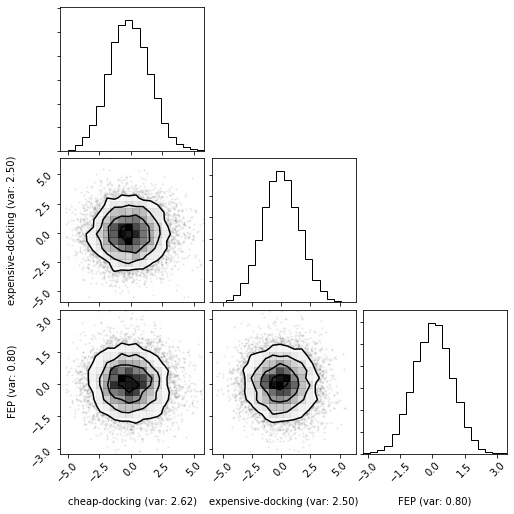

In [8]:
# We now plot these noise distributions using a corner plot

labels = [f"{name} (var: {var:.2f})" for name, var in zip(noise_names, np.var(noises_together,axis=0))]
corner.corner(noises_together, labels=labels)
plt.show()